In [2]:
!wget https://raw.githubusercontent.com/Rexhaif/ner-dialogues-hackathon/master/data/train.conll
!wget https://raw.githubusercontent.com/Rexhaif/ner-dialogues-hackathon/master/data/test.conll

--2021-03-12 15:10:28--  https://raw.githubusercontent.com/Rexhaif/ner-dialogues-hackathon/master/data/train.conll
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 126336 (123K) [text/plain]
Сохранение в: «train.conll»

train.conll         100%[===================>] 123,38K  --.-KB/s    за 0,07s   

2021-03-12 15:10:28 (1,78 MB/s) - «train.conll» сохранён [126336/126336]

--2021-03-12 15:10:28--  https://raw.githubusercontent.com/Rexhaif/ner-dialogues-hackathon/master/data/test.conll
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожида

In [157]:
import pymorphy2
import spacy
import pandas as pd
import numpy as np

In [158]:
nlp = spacy.load("en_core_web_sm")

morph = pymorphy2.MorphAnalyzer()

In [159]:
with open('train.conll') as train_f, open('test.conll') as test_f:
    train_str = train_f.read()
    test_str = test_f.read()

In [160]:
data_str = train_str + test_str

In [161]:
def get_word_pos(word, sent):
    pos = morph.parse(word[0])[0].tag.POS
    if not pos:
        i = sent.index(word)
        sent = ' '.join([tok[0] for tok in sent]).capitalize()
        doc = nlp(sent)
        pos = doc[i].pos_
    return pos

In [168]:
def get_sent_num(word_i, sent_i):
    if word_i:
        return np.nan
    return f'Sentence: {sent_i+1}'

In [169]:
def parse_conll(conll_str):
    sents = [tuple(sent.split()) for sent in conll_str.split('\n\n')]
    splitted_sents = []
    for i, sent in enumerate(sents):
        it = iter(sent)
        splitted_sents.append(list(zip(it, it)))
    parsed_sents = [{'Sentence #': get_sent_num(word_i, sent_i), 'Word': word[0],
                     'POS': get_word_pos(word, sent), 'Tag': word[1]}
                    for sent_i, sent in enumerate(splitted_sents) for word_i, word in enumerate(sent)]
    return parsed_sents

In [170]:
# train_sents = parse_conll(train_str)
# test_sents = parse_conll(test_str)

In [171]:
data_sents = parse_conll(data_str)

In [172]:
data = pd.DataFrame(data_sents)

In [173]:
data

,Sentence #,Word,POS,Tag
0,Sentence: 1,спой,VERB,O
1,NaN,из,PREP,O
2,NaN,шоколад,NOUN,B-FILM
3,NaN,песню,NOUN,O
4,NaN,LItaliano,NOUN,B-SONG
...,...,...,...,...
9077,NaN,лгунья,NOUN,I-BOOK
9078,Sentence: 2521,давай,VERB,O
9079,NaN,послушаем,VERB,O
9080,NaN,авессалом,NOUN,B-BOOK


In [174]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [175]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,спой,VERB,O,2395,1
1,NaN,из,PREP,O,1460,1
2,NaN,шоколад,NOUN,B-FILM,2307,3
3,NaN,песню,NOUN,O,1817,1
4,NaN,LItaliano,NOUN,B-SONG,84,8


In [176]:
# Fill na
data_fillna = data.fillna(method='ffill', axis=0)
# Groupby and collect columns
data_group = data_fillna.groupby(
['Sentence #'],as_index=False
)['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))
# Visualise data
data_group.head()

<ipython-input-176-04716ffa74c4>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_group = data_fillna.groupby(


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[спой, из, шоколад, песню, LItaliano]","[VERB, PREP, NOUN, NOUN, NOUN]","[O, O, B-FILM, O, B-SONG]","[2395, 1460, 2307, 1817, 84]","[1, 1, 3, 1, 8]"
1,Sentence: 10,"[проиграй, уэмом]","[VERB, NOUN]","[O, B-SINGER]","[2904, 71]","[1, 2]"
2,Sentence: 100,"[давай, послушаем, долго, прощани]","[VERB, VERB, ADVB, NOUN]","[O, O, B-BOOK, I-BOOK]","[625, 2128, 2758, 684]","[1, 1, 4, 9]"
3,Sentence: 1000,"[расскажи, хаи, хоупс]","[VERB, NOUN, NOUN]","[O, B-SONG, I-SONG]","[752, 2714, 3280]","[1, 8, 0]"
4,Sentence: 1001,"[включи, джорни]","[VERB, NOUN]","[O, B-SINGER]","[2917, 1807]","[1, 2]"


In [177]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [178]:
def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 1701 
train_tokens length: 1701 
test_tokens length: 253 
test_tags: 253 
val_tokens: 567 
val_tags: 567


## Build the model architecture

In [180]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

In [181]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [182]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim,
      '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  3346 
output_dim:  64 
input_length:  15 
n_tags:  11


In [183]:
import tensorflow_addons as tfa

In [184]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim,
                        output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True,
                                 dropout=0.2, recurrent_dropout=0.2), merge_mode='concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True,
                   dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    # Optimiser
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

In [185]:
def train_model(X, y, model):
    loss = list()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 15, 64)            214144    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 15, 128)           66048     
_________________________________________________________________
lstm_35 (LSTM)               (None, 15, 64)            49408     
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 11)            715       
Total params: 330,315
Trainable params: 330,315
Non-trainable params: 0
_________________________________________________________________


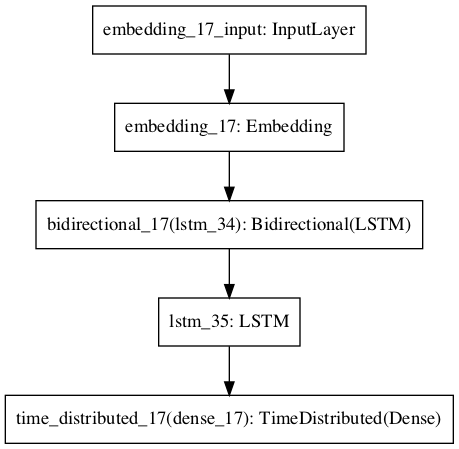

In [186]:
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)

In [187]:
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

2/2 [==============================] - 0s 171ms/step - loss: 0.6262 - accuracy: 0.8640 - val_loss: 0.5127 - val_accuracy: 0.8612


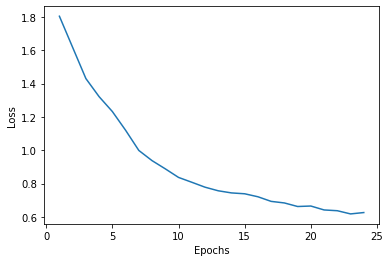

In [188]:
import matplotlib.pyplot as plt
plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs');
plt.ylabel('Loss');

In [189]:
results

,with_add_lstm
0,NaN
1,1.803707
2,1.616841
3,1.429892
4,1.321222
5,1.232188
6,1.119928
7,0.998792
8,0.937622
9,0.888449


In [201]:
model_bilstm_lstm.predict(test_tokens)
metric = tfa.metrics.F1Score(len(test_tags), 'micro')

In [205]:
metric(test_tokens, train_tokens)

TypeError: in user code:

    /opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.8/site-packages/tensorflow_addons/metrics/f_scores.py:129 update_state  *
        y_pred = tf.logical_and(y_pred >= threshold, tf.abs(y_pred) > 1e-12)
    /opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:3893 greater
        _result = pywrap_tfe.TFE_Py_FastPathExecute(

    TypeError: Cannot convert 1e-12 to EagerTensor of dtype int32
